In [1]:
# General libraries
import os
import shutil
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [2]:
# Distribution of the datasets
input_path='/Users/neeharikasinha/Documents/datascience-course/Capstone1/Chestxray-cardiomegaly3/CXR_img/'
for img in ['train', 'test']:
    n_normal = len(os.listdir(input_path + img + '/normal'))
    n_infect = len(os.listdir(input_path + img + '/cardiomegaly'))
    print('Image_sets: {}, Normal images: {}, Cardiomegaly images: {}'.format(img, n_normal, n_infect))

Image_sets: train, Normal images: 50500, Cardiomegaly images: 1707
Image_sets: test, Normal images: 9861, Cardiomegaly images: 1069


In [3]:
input_path='/Users/neeharikasinha/Documents/datascience-course/Capstone1/Chestxray-cardiomegaly3/CXR_img/'

# we are now going to process the images, to scale all in same size and image augmentaion. 
# Which will then be fed to the neural network in the specified batch sizes and image dimensions

def process_data(img_dims, batch_size):
    
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    #Takes the path to a directory & generates batches of augmented data
    
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    #The labels for the images in test data are porcessed in one batch size, to get the confusion matrix
    
    test_data = []
    test_labels = []

    for cond in ['/normal/', '/cardiomegaly/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims)) # resize the image for a given dimension
            img = np.dstack([img, img, img]) # Stack them all
            img = img.astype('float32') / 255
            if cond=='/normal/':
                label = 0
            elif cond=='/cardiomegaly/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    test_data = [np.zeros((img_dims,img_dims,3)), np.zeros((img_dims,img_dims,3)), np.zeros((epochs,img_dims,3))]  
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [5]:
# Hyperparameters
img_dims = 128
epochs = 5
batch_size = 32

 
# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 52207 images belonging to 2 classes.
Found 10930 images belonging to 2 classes.


In [6]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3)) # as we have stack 3 img together we use the attribut "3"

# First convolution layer 
#https://stackoverflow.com/questions/44410135/keras-conv2d-own-filters

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x) # pooling the image index by 2,2 

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x) 

# FC (fully connected layer)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [7]:
# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/5
1631/1631 [==============================] - 1617s 991ms/step - loss: 0.1623 - accuracy: 0.9671 - val_loss: 0.5597 - val_accuracy: 0.9022
Epoch 2/5
1631/1631 [==============================] - 1545s 948ms/step - loss: 0.1484 - accuracy: 0.9673 - val_loss: 0.4187 - val_accuracy: 0.9025
Epoch 3/5
1631/1631 [==============================] - 1544s 947ms/step - loss: 0.1426 - accuracy: 0.9673 - val_loss: 0.4820 - val_accuracy: 0.9015

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/5
1631/1631 [==============================] - 1544s 947ms/step - loss: 0.1301 - accuracy: 0.9672 - val_loss: 0.1607 - val_accuracy: 0.9027
Epoch 5/5
1631/1631 [==============================] - 1542s 946ms/step - loss: 0.1250 - accuracy: 0.9674 - val_loss: 0.2933 - val_accuracy: 0.9021

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.


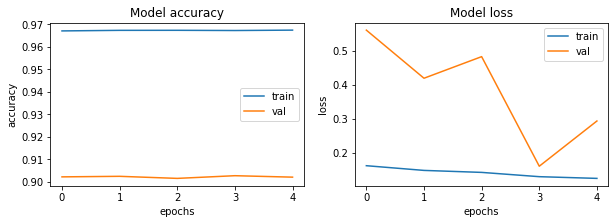

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (3, 1)